In [1]:
import pandas as pd 
import wandb
import numpy as np
api = wandb.Api()

In [8]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
metrics = ['test/result_acc/eval/'+ x for x in ['I', 'SS', 'LS', 'SL', 'LL']] + ['test/result_acc/avg']

In [123]:
def filter_run(summary):
    return True

runs = api.runs("qli/HINT_scaling_law")
summary_list = [] 
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary = {'name': run.name}
    summary.update(run.summary._json_dict)
    summary.update(run.config)
    if filter_run(summary):
        summary_list.append(summary)
df = {k: [x.get(k, '') for x in summary_list] for k in summary_list[0]}
df = pd.DataFrame(df)
print('number of runs:', len(summary_list))

number of runs: 50


Target accuracy: 90, N: 10^33


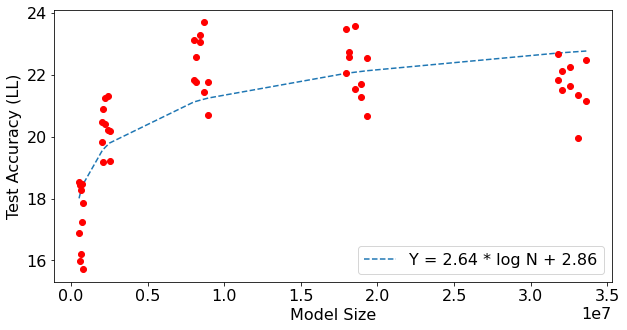

In [124]:
from scipy.optimize import curve_fit

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

def func_loglinear(x, a, b):
    return a * np.log10(x) + b

target_func = func_loglinear

X = df['n_params']
y = df[metrics[4]] * 100

data = list(zip(X, y))
data.sort()
X = [d[0] for d in data]
y = [d[1] for d in data]

popt, pcov = curve_fit(target_func, X, y)
a, b = popt
equation = f'Y = {a:.2f} * log N + {b:.2f}'
target_acc = 90
logN = (target_acc - b) / a 
print(f'Target accuracy: {target_acc}, N: 10^{logN:.0f}')

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10, 5))
plt.plot(X, target_func(X, *popt), '--', label=equation)
plt.plot(X, y, 'ro')
plt.xlabel('Model Size')
plt.ylabel('Test Accuracy (LL)')
plt.legend(loc='lower right')
plt.savefig('figures/scaling_law_model.png', dpi=300, bbox_inches='tight')
plt.show()

In [125]:
def filter_run(summary):
    return summary.get('train_size') is not None

runs = api.runs("qli/HINT")
summary_list = [] 
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary = {'name': run.name}
    summary.update(run.summary._json_dict)
    summary.update(run.config)
    if filter_run(summary):
        summary_list.append(summary)
df = {k: [x.get(k, '') for x in summary_list] for k in summary_list[0]}
df = pd.DataFrame(df)
print('number of runs:', len(summary_list))

number of runs: 12


Target accuracy: 90, N: 10^15


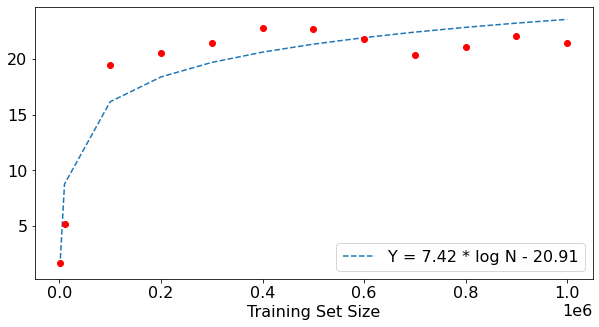

In [126]:
def func_loglinear(x, a, b):
    return a * np.log10(x) + b

target_func = func_loglinear

X = df['train_size'] * 1e6
y = df[metrics[4]] * 100

data = list(zip(X, y))
data.sort()
X = [d[0] for d in data]
y = [d[1] for d in data]

popt, pcov = curve_fit(target_func, X, y)
a, b = popt
equation = f'Y = {a:.2f} * log N ' + ('-' if b < 0 else '+') + f' {abs(b):.2f}'
target_acc = 90
logN = (target_acc - b) / a 
print(f'Target accuracy: {target_acc}, N: 10^{logN:.0f}')

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10, 5))
plt.plot(X, target_func(X, *popt), '--', label=equation)
plt.plot(X, y, 'ro')
plt.xlabel('Training Set Size')
# plt.ylabel('Test Accuracy (LL)')
plt.legend(loc='lower right')
plt.savefig('figures/scaling_law_data.png', dpi=300, bbox_inches='tight')
plt.show()